# Testing preprocessing techniques

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


2023-04-03 21:14:50.797540: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
tfds.__version__

'4.8.2'

In [6]:
dataset = tfds.load('bdd')

(720, 1280, 3)


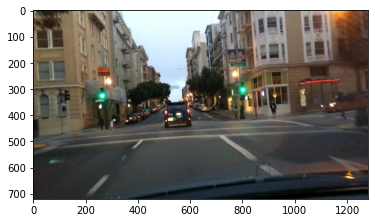

(720, 1280, 1)


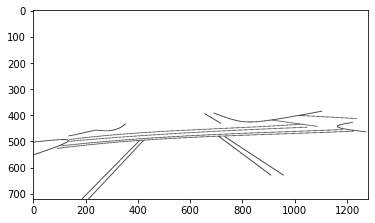

In [15]:
train_set = dataset['train']

for example in train_set:
    print(example['image'].shape)
    plt.imshow(example['image'])
    plt.show()
    print(example['label'].shape)
    plt.imshow(example['label'], cmap='gray')
    plt.show()
    break

In [ ]:
import sys

np.set_printoptions(threshold=sys.maxsize)

for entry in dataset['train']:
  # print(entry['label'])
  lab = entry['label']
  # print(len(lab))
  # print(len(lab[lab==4]))

  print(np.count_nonzero(lab < 255))

  # Replace pixel values equal to 255 with 0, else 1
  # 255 pixel values arn't lane lines and other pixel
  # values are neglected since other subtasks of lane marking
  # are ignored.
  lab = np.where(lab == 255, 0, 1) 


  ''' MAY NEED THIS SINCE KERAS EXPECTS DATA AS TUPLES '''
  # dataset['train'].map(lambda items: (items['image'], items['label']))

  print(np.count_nonzero(lab == 1))

  break

## Preproc testing:

In [1]:
def preprocess(instance):
  # Potential dimmensionality reduction (consider different shapes):
  # input_image = tf.image.resize(datapoint['image'], (128, 128))

  # Normalize the input to 0-1 range
  input_image = tf.cast(instance['image'], tf.float32) / 255.0

  # Replace pixel values equal to 255 with 0, else 1
  # 255 pixel values arn't lane lines and other pixel
  # values are neglected since other subtasks of lane marking
  # are ignored.
  bitmask_label = tf.where(instance['label'] == 255, 1, 0) 

  return (input_image, bitmask_label)

def load_10k_data():
  # Retrieve custom tfds of BDD10k datatset
  dataset = tfds.load('bdd')


  
  train_set = dataset['train'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
  validate_set = dataset['test'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
  test_set = dataset['validate'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
  
  return train_set, validate_set, test_set


Manual 'preprocess' function testing:

Number of lane line pixels  17021
Number of lane line pixels after preprocessing 17021


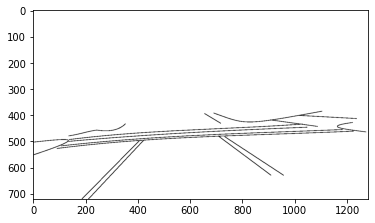

In [80]:
data = tfds.load('bdd')
train = data['train']

for item in train:
  print("Number of lane line pixels ", np.count_nonzero(item['label'] < 255))
  image, label = preprocess(item)
  print("Number of lane line pixels after preprocessing", np.count_nonzero(label == 0))
  plt.imshow(label, cmap="gray")
  break

Number of lane line pixels after preprocessing 17021


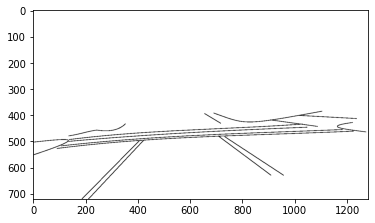

In [79]:
train, valid, test = load_10k_data()

for item in train:
  print("Number of lane line pixels after preprocessing", np.count_nonzero(item[1] == 0))
  plt.imshow(item[1], cmap="gray")
  break

In [3]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def create_MobileNetV2_model():
  base_model = tf.keras.applications.ResNet50V2(input_shape=[720, 1280, 3], include_top=False)

  # Use the activations of these layers
  layer_names = [
    "conv1_conv",          # (None, 360, 640, 64)
    "conv2_block1_3_conv", # (None, 180, 320, 256)
    "conv2_block3_2_conv", # (None, 90, 160, 64)
    "conv4_block6_1_relu", # (None, 45, 80, 256)
    # "conv5_block1_1_relu" # (None, 23, 40, 512)
  ]
  
  base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

  # Create the feature extraction model
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

  down_stack.trainable = False

  up_stack = [
    upsample(512, 3),  # 45x80 -> 90,160
    upsample(256, 3),  
    upsample(128, 3),  
    upsample(128, 3),  
    upsample(128, 3),  

  ]
  # print(down_stack.summary())

  return up_stack, down_stack

def resnet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[720, 1280, 3])

  up_stack, down_stack = create_MobileNetV2_model()

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

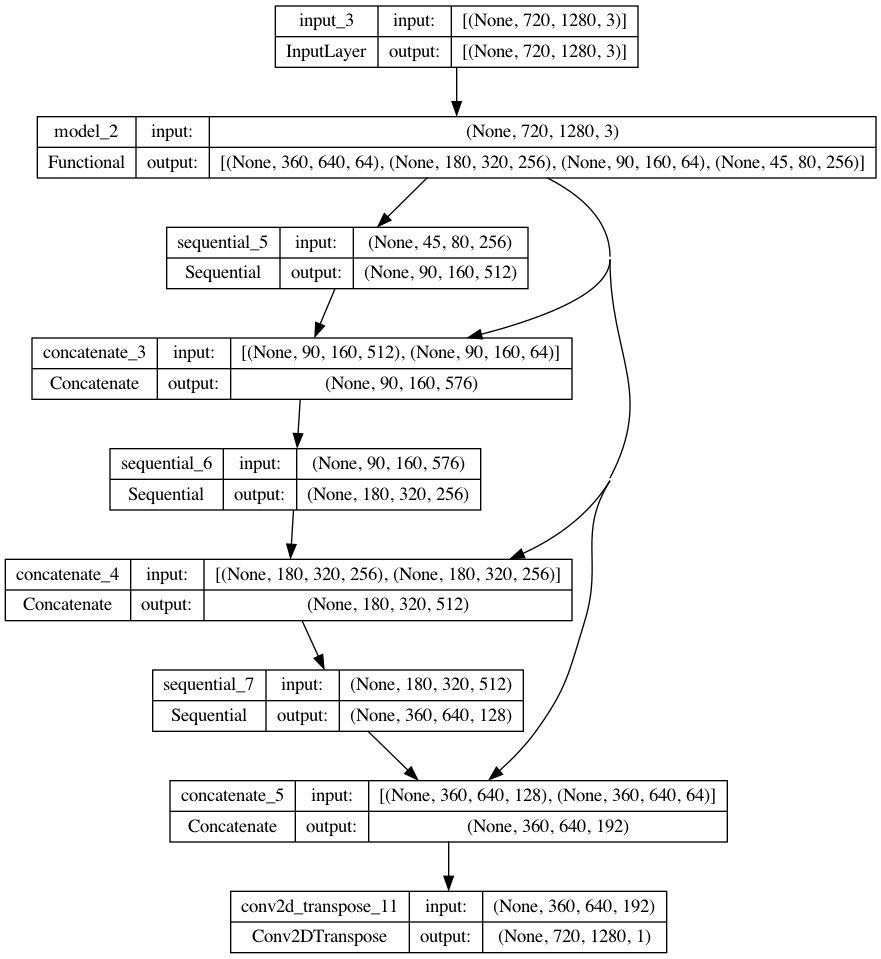

In [16]:
import tensorflow_datasets as tfds
from tensorflow import keras

def preprocess(instance):
  # Potential dimmensionality reduction (consider different shapes):
  # input_image = tf.image.resize(datapoint['image'], (128, 128))

  # Normalize the input to 0-1 range
  input_image = tf.cast(instance['image'], tf.float32) / 255.0

  # Replace pixel values equal to 255 with 0, else 1
  # 255 pixel values arn't lane lines and other pixel
  # values are neglected since other subtasks of lane marking
  # are ignored.
  bitmask_label = tf.where(instance['label'] == 255, 1, 0) 

  return (input_image, bitmask_label)

# Loads a subset of the bdd100k dataset and returns it.
# The dataset contains "train", "validate", and "test" sections
def load_10k_data():
  # Retrieve custom tfds of BDD10k datatset
  dataset = tfds.load('bdd')

  train_set = dataset['train'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
  validate_set = dataset['test'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
  test_set = dataset['validate'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
  
  return train_set, validate_set, test_set



model = resnet_model(output_channels=1)
tf.keras.utils.plot_model(model, show_shapes=True)


(720, 1280, 3)
(1, 720, 1280, 3)
1/1 [==============================] - 2s 2s/step
pred_mask shape =  (1, 720, 1280, 1)


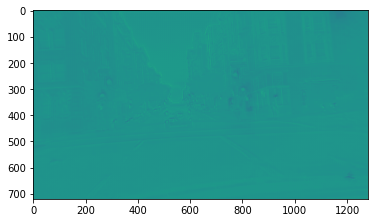

In [4]:
def preprocess(instance):
  # Potential dimmensionality reduction (consider different shapes):
  # input_image = tf.image.resize(datapoint['image'], (128, 128))

  # Normalize the input to 0-1 range
  input_image = tf.cast(instance['image'], tf.float32) / 255.0

  # Replace pixel values equal to 255 with 0, else 1
  # 255 pixel values arn't lane lines and other pixel
  # values are neglected since other subtasks of lane marking
  # are ignored.
  bitmask_label = tf.where(instance['label'] == 255, 1, 0) 

  return (input_image, bitmask_label)

# Loads a subset of the bdd100k dataset and returns it.
# The dataset contains "train", "validate", and "test" sections
def load_10k_data():
  # Retrieve custom tfds of BDD10k datatset
  dataset = tfds.load('bdd')

  train_set = dataset['train'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
  validate_set = dataset['test'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
  test_set = dataset['validate'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
  
  return train_set, validate_set, test_set



train_set, validate_set, test_set = load_10k_data()
model = resnet_model(output_channels=1)


# Test untrained model to see what output it produces
for data in train_set:
  print(data[0].shape)
  dat_img = data[0]
  dat_new = dat_img[None,:,:,:] # Add extra dimmension to satisfy model 
  print(dat_new.shape)
  pred_mask = model.predict(dat_new)
  print("pred_mask shape = ", pred_mask.shape)
  plt.imshow(pred_mask[0])
  plt.show()
  break



In [105]:
''' PRINTING ALL LAYERS AND SHAPES FOR RESNET MODEL '''

# base_model = tf.keras.applications.ResNet50V2(input_shape=[720, 1280, 3], include_top=False)

# for layer in base_model.layers:
#   print(layer.name, layer.output_shape)

' PRINTING ALL LAYERS AND SHAPES FOR RESNET MODEL '